In [10]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import torch.nn.functional as F
import numpy as np
import soundfile as sf
from torch.utils.data import DataLoader
from models.model_scalar_v2 import MixingModelScalar2d
from data.dataset import MultitrackAudioDataset
from data.dataset_utils import split_songlist
from data.medleydb_split import weathervane_music, musdb18_not_in_medleydb

from ignite.engine import Engine, Events
from ignite.metrics import Loss
from ignite.handlers import ModelCheckpoint, EarlyStopping, global_step_from_engine

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch version: ', torch.__version__)
print('Device: ', device)

Torch version:  1.6.0
Device:  cuda


In [3]:
base_path = '/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio'
weights_dir = './saved_models'
chunk_length = 1

In [4]:
train_songlist, val_songlist, test_songlist = split_songlist(weathervane_music + musdb18_not_in_medleydb,
                                                            train_val_test_split=(0.8, 0.2, 0.0),
                                                            summary=True)

Dataset split:
Train: 64 tracks
['FacesOnFilm_WaitingForGa', "The Wrong'Uns - Rothko", 'Leaf - Summerghost', 'Grants_PunchDrunk', 'Fergessen - Back From The Start', 'Jay Menon - Through My Eyes', 'InvisibleFamiliars_DisturbingWildlife', 'Grants - PunchDrunk', 'Actions - South Of The Water', 'James May - If You Say', 'Johnny Lokke - Promises & Lies', 'The Long Wait - Back Home To Blue', 'James May - All Souls Moon', 'NightPanther_Fire', 'Flags - 54', 'Cnoc An Tursa - Bannockburn', 'AvaLuna_Waterduct', 'Bill Chudziak - Children Of No-one', 'Traffic Experiment - Sirens', 'Wall Of Death - Femme', 'Actions - One Minute Smile', 'Young Griffo - Blood To Bone', 'Snowmine_Curfews', 'ANiMAL - Clinic A', 'TheDistricts_Vermont', 'Leaf - Come Around', 'PurlingHiss_Lolita', 'Traffic Experiment - Once More (With Feeling)', 'SecretMountains_HighHorse', 'Giselle - Moss', 'Remember December - C U Next Time', 'St Vitus - Word Gets Around', 'Hollow Ground - Left Blind', 'StrandOfOaks_Spacestation', 'Patri

In [4]:
train_songlist = ['CelestialShore_DieForUs', 'HeladoNegro_MitadDelMundo', 'Lushlife_ToynbeeSuite', 'FamilyBand_Again', 'SweetLights_YouLetMeDown', 'AvaLuna_Waterduct', 'TheSoSoGlos_Emergency', 'PurlingHiss_Lolita', 'TheDistricts_Vermont', 'BigTroubles_Phantom', 'AClassicEducation_NightOwl', 'Auctioneer_OurFutureFaces', 'InvisibleFamiliars_DisturbingWildlife', 'SecretMountains_HighHorse', 'Grants_PunchDrunk', 'Snowmine_Curfews', 'NightPanther_Fire', 'HezekiahJones_BorrowedHeart', 'DreamersOfTheGhetto_HeavyLove', 'HopAlong_SisterCities']
val_songlist = ['StevenClark_Bounty', 'StrandOfOaks_Spacestation', 'PortStWillow_StayEven', 'FacesOnFilm_WaitingForGa', 'Creepoid_OldTree']

In [4]:
d_train = MultitrackAudioDataset(
    base_path,
    songlist=train_songlist,
    chunk_length=chunk_length,
    normalize=False,
    compute_features=True,
    augment_data=True
)

d_val = MultitrackAudioDataset(
    base_path,
    songlist=val_songlist,
    chunk_length=chunk_length,
    normalize=False,
    compute_features=True,
    augment_data=True
)

print('Train: {} tracks, {} chunks'.format(d_train.get_num_songs(), len(d_train)))
print('Val: {} tracks, {} chunks'.format(d_val.get_num_songs(), len(d_val)))

Train: 1 tracks, 289 chunks
Val: 1 tracks, 243 chunks


In [5]:
train_loader = DataLoader(d_train,
                          batch_size=64,
                          shuffle=False,
                          num_workers=8,
                          pin_memory=True,
                          drop_last=False,
                          timeout=0,
                          worker_init_fn=None)

val_loader = DataLoader(d_val,
                        batch_size=64,
                        shuffle=False,
                        num_workers=8,
                        pin_memory=True,
                        drop_last=False,
                        timeout=0,
                        worker_init_fn=None)

-150.95375 -88.89559 125.68944
-1.0 -0.58889294 0.8326354


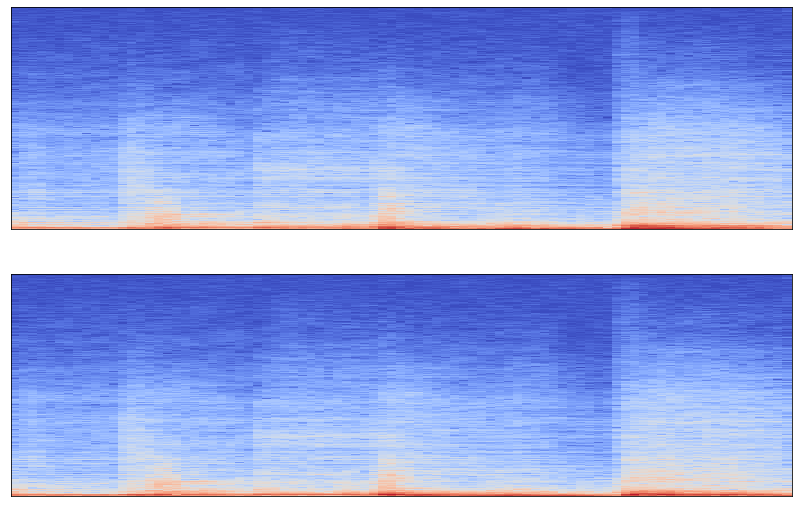

In [6]:
train_features, gt_features = d_train[50]

features = np.sum(train_features, axis=0)

fig = plt.figure(figsize=(14, 9))

ax1 = plt.subplot(2,1,1)
print(np.min(features), np.mean(features), np.max(features))
librosa.display.specshow(features)

ax2 = plt.subplot(2,1,2, sharex=ax1)
norm_features = librosa.util.normalize(features)
print(np.min(norm_features), np.mean(norm_features), np.max(norm_features))
librosa.display.specshow(norm_features)
plt.show()

In [6]:
model = MixingModelScalar2d().to(device)

num_trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('{} trainable parameters'.format(num_trainable_param))

908400 trainable parameters


In [7]:
weights = './saved_models/scalar2d_scalar2d_2550.pt'
model.load_state_dict(torch.load(weights, map_location=device))

<All keys matched successfully>

In [7]:
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

In [8]:
metrics = {
    'mse': Loss(criterion)
}


def train_step(trainer, batch):
    model.train()
    optimizer.zero_grad()

    train_features, gt_features = batch
    masked, _ = model(train_features.float().to(device))

#     masked = F.normalize(masked)
#     gt_features = F.normalize(gt_features)

    loss = criterion(masked, gt_features.float().to(device))
    loss.backward()
    optimizer.step()

    return loss.item()


def inference_step(engine, batch):
    model.eval()

    with torch.no_grad():
        train_features, gt_features = batch
        masked, _ = model(train_features.float().to(device))

#         masked = F.normalize(masked)
#         gt_features = F.normalize(gt_features)
        
        return masked, gt_features.float().to(device)

    
trainer = Engine(train_step)

train_evaluator = Engine(inference_step)
for name, metric in metrics.items():
    metric.attach(train_evaluator, name)


val_evaluator = Engine(inference_step)
for name, metric in metrics.items():
    metric.attach(val_evaluator, name)

In [11]:
def score_function(engine):
    return -engine.state.metrics['mse']


checkpointer = ModelCheckpoint(
    dirname=weights_dir,
    filename_prefix='',
    score_name='neg_train_loss',
    score_function=score_function,
    global_step_transform=global_step_from_engine(trainer),
    # keep all the objects
    n_saved=None,
    create_dir=True,
    save_as_state_dict=True,
    require_empty=False
)
model_name = 'scalar2d_{}s'.format(chunk_length)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {model_name: model})


handler = EarlyStopping(
    patience=7,
    score_function=score_function,
    trainer=trainer
)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

In [12]:
training_history = {
    'loss': []
}
validation_history = {
    'loss': []
}

@trainer.on(Events.ITERATION_COMPLETED(every=30))
def log_training_loss(trainer):
    print("{}/{} : {} - loss: {:.5f}"
          .format(trainer.state.epoch, trainer.state.max_epochs,
                  trainer.state.iteration, trainer.state.output))

    
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    loss = metrics['mse']
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}, Avg loss: {:.5f}"
          .format(trainer.state.epoch, loss))

    
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    loss = metrics['mse']
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}, Avg loss: {:.5f}"
          .format(trainer.state.epoch, loss))

In [ ]:
trainer.run(train_loader, max_epochs=20)

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(training_history['loss'], label='Train loss')
plt.plot(validation_history['loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');
plt.xlim(0, 70)
plt.legend()
plt.tight_layout()
plt.savefig('{}/loss.png'.format(weights_dir))